# Automatic Feature Engineering with Featuretools
by Matthew Emery

In [55]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import featuretools as ft
from random import sample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from itertools import chain
import seaborn as sns
import numpy as np
from IPython.core.debugger import set_trace
%matplotlib inline

warnings.filterwarnings('ignore')

In [48]:
train_df = pd.read_csv("data/train.csv")
train_target = train_df["Survived"]
train_features = train_df.drop(columns="Survived")
train_features['Pclass'] = train_features['Pclass'].astype('category')
train_features.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
837,838,3,"Sirota, Mr. Maurice",male,NaN,0,0,392092,8.0500,NaN,S
52,53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
467,468,1,"Smart, Mr. John Montgomery",male,56.0,0,0,113792,26.5500,NaN,S
282,283,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S
104,105,3,"Gustafsson, Mr. Anders Vilhelm",male,37.0,2,0,3101276,7.9250,NaN,S


In [21]:
basic_features = pd.get_dummies(train_features.drop(columns=["Name", "PassengerId", "Ticket", "Cabin"]))

dummy_model = DummyClassifier(random_state=0)
dummy_cv = cross_val_score(dummy_model, basic_features, train_target, cv=10)
dummy_cv.mean(), dummy_cv.std()

(0.553259845647486, 0.05365918336658586)

In [70]:
basic_model = XGBClassifier()
basic_cv = cross_val_score(basic_model, basic_features, train_target, cv=5)
basic_cv.mean(), basic_cv.std()

(0.8216037594328934, 0.01872542260680136)

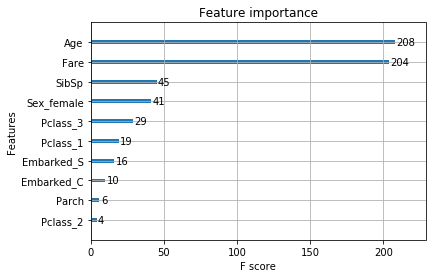

In [71]:
basic_model.fit(basic_features, train_target)
plot_importance(basic_model, max_num_features=20)

In [49]:
#How about some feature engineering?
ft_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=ft_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

In [25]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,embarkeds.MEAN(titanic.Parch),embarkeds.MEAN(titanic.Fare),embarkeds.COUNT(titanic),embarkeds.NUM_UNIQUE(titanic.Pclass),embarkeds.NUM_UNIQUE(titanic.Sex),embarkeds.MODE(titanic.Pclass) = 3.0,embarkeds.MODE(titanic.Pclass) = 1.0,embarkeds.MODE(titanic.Pclass) = unknown,embarkeds.MODE(titanic.Sex) = male,embarkeds.MODE(titanic.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
506,18.0,1,0,108.9000,0,1,0,0,1,0,...,0.363095,59.954144,168.0,3.0,2.0,0,1,0,1,0
871,26.0,0,0,7.8958,1,0,0,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
792,16.0,0,0,26.0000,0,0,1,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
481,9.0,5,2,46.9000,1,0,0,0,1,0,...,0.413043,27.079812,644.0,3.0,2.0,1,0,0,1,0
182,NaN,0,0,15.0500,0,0,1,0,1,0,...,0.363095,59.954144,168.0,3.0,2.0,0,1,0,1,0


In [68]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.features = None
        
    def fit(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        _, self.features = ft.encode_features(entity_set, features)
        return self

    def transform(self, X, y=None):
        if not self.features:
            raise ValueError("Fit the FeaturetoolsTransformer first")
        else:
            entity_set = self._create_entity(X)
            X = ft.calculate_feature_matrix(self.features, entityset=entity_set)
            return X
        
    def _create_entity(self, X):
        X = X.reset_index()
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index = "index",
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        return es

In [73]:
ft_transformer = FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"])
ft_transformer.fit_transform(ft_features).sample(5)

,PassengerId,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,...,Embarked.MEAN(id.Parch),Embarked.MEAN(id.Fare),Embarked.COUNT(id),Embarked.NUM_UNIQUE(id.Pclass),Embarked.NUM_UNIQUE(id.Sex),Embarked.MODE(id.Pclass) = 3.0,Embarked.MODE(id.Pclass) = 1.0,Embarked.MODE(id.Pclass) = unknown,Embarked.MODE(id.Sex) = male,Embarked.MODE(id.Sex) = unknown
index,,,,,,,,,,,,,,,,,,,,,
751,752,6.0,0,1,12.4750,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
332,333,38.0,0,1,153.4625,False,True,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
498,499,25.0,1,2,151.5500,False,True,False,False,False,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
212,213,22.0,0,0,7.2500,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False
592,593,47.0,0,0,7.2500,True,False,False,False,True,...,0.413043,27.079812,644.0,3.0,2.0,True,False,False,True,False


In [74]:
sample(ft_transformer.features, 5)

[<Feature: Pclass = unknown>,
 <Feature: Pclass.SUM(id.Age)>,
 <Feature: Sex.STD(id.SibSp)>,
 <Feature: Pclass.MIN(id.PassengerId)>,
 <Feature: Embarked.MEAN(id.Parch)>]

In [76]:
ft_pipeline = make_pipeline(FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"]),
              XGBClassifier())

In [77]:
ft_cv = cross_val_score(ft_pipeline, ft_features, train_target, cv=5)
ft_cv.mean(), ft_cv.std()

(0.7813551165389443, 0.08468313077244315)

In [10]:
train_features['CabinClass'] = train_features["Cabin"].str.get(0)
train_features['LastName'] = train_features['Name'].str.split(", ").apply(lambda x: x[0])
train_features['Honorific'] = train_features['Name'].str.extract(" ([a-zA-z]+)")
train_features['TicketPrefix'] = train_features['Ticket'].str.extract("(.+) ")
# train_features['TicketNumber'] = train_features['Ticket'].str.extract("([0-9]+)$").astype(float)
train_features = train_features.drop(columns=["Name", "Cabin", "Ticket"])

In [11]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

Built 270 features
Elapsed: 00:07 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,ticketprefixes.MODE(titanic.LastName) = Corn,ticketprefixes.MODE(titanic.LastName) = Hakkarainen,ticketprefixes.MODE(titanic.LastName) = unknown,ticketprefixes.MODE(titanic.Honorific) = Mr,ticketprefixes.MODE(titanic.Honorific) = Miss,ticketprefixes.MODE(titanic.Honorific) = Master,ticketprefixes.MODE(titanic.Honorific) = Capt,ticketprefixes.MODE(titanic.Honorific) = Rev,ticketprefixes.MODE(titanic.Honorific) = Mrs,ticketprefixes.MODE(titanic.Honorific) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
842,16.0,0,0,10.5000,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
304,NaN,0,0,12.3500,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
294,24.0,0,0,8.8500,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
494,71.0,0,0,49.5042,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
63,45.0,1,0,83.4750,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [12]:
expanded_ft_cv = cross_val_score(basic_model, feature_matrix, train_target, cv=10)
expanded_ft_cv.mean(), expanded_ft_cv.std()

(0.8283861082737486, 0.027312258020298144)

In [13]:
pipeline = make_pipeline(
    Imputer(strategy='median'),
    SelectFromModel(ExtraTreesClassifier(random_state=20, n_estimators=500), 'median'),
    XGBClassifier(random_state=20, n_estimators=500)
)

selected_ft_cv = cross_val_score(pipeline, feature_matrix, train_target, cv=10)
selected_ft_cv.mean(), selected_ft_cv.std()

(0.8272494609011464, 0.02956420556342132)

In [14]:
basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv

(array([0.78888889, 0.82222222, 0.7752809 , 0.84269663, 0.88764045,
        0.80898876, 0.83146067, 0.76404494, 0.82022472, 0.85227273]),
 array([0.78888889, 0.85555556, 0.7752809 , 0.83146067, 0.8988764 ,
        0.83146067, 0.83146067, 0.7752809 , 0.82022472, 0.84090909]),
 array([0.78888889, 0.81111111, 0.79775281, 0.86516854, 0.86516854,
        0.80898876, 0.84269663, 0.82022472, 0.82022472, 0.86363636]),
 array([0.76666667, 0.82222222, 0.79775281, 0.85393258, 0.86516854,
        0.82022472, 0.86516854, 0.80898876, 0.83146067, 0.84090909]))

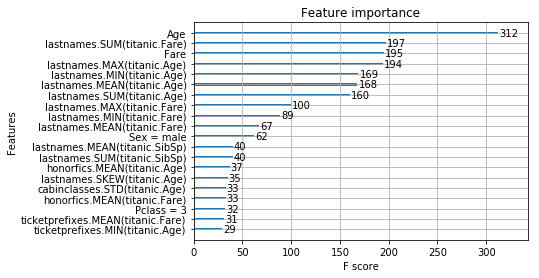

In [15]:
basic_model.fit(feature_matrix, train_target)
plot_importance(basic_model, max_num_features=20)

In [16]:
df = pd.DataFrame(
    {"Model": list(chain.from_iterable([[x] * 10 for x in ("Basic Features", 
                                                           "Naive Featuretools",
                                                           "Smarter Featuretools",
                                                           "Selected Featuretools")])),
        "CV Fold Accuracy": np.concatenate([basic_cv, ft_cv, expanded_ft_cv, selected_ft_cv])} )

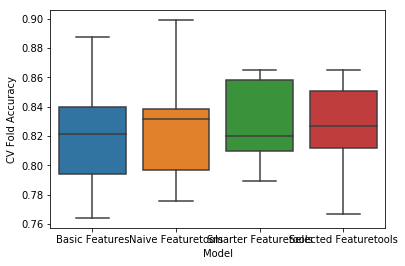

In [17]:
sns.boxplot("Model", "CV Fold Accuracy", data = df)